In [9]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from battery import Battery
%matplotlib widget

In [10]:
# Load the data into the variable DF
df=pd.read_csv('PV_raw_data.csv')

df

,Month,Day,Hour,Beam Irradiance (W/m2),Diffuse Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Albedo,Plane of Array Irradiance (W/m2),Cell Temperature (C),DC Array Output (W),AC System Output (W)
0,1,1,0,0,0,9.5,3.4,0.15,0.0,9.5,0.0,0.0
1,1,1,1,0,0,9.2,3.6,0.15,0.0,9.2,0.0,0.0
2,1,1,2,0,0,9.0,3.4,0.15,0.0,9.0,0.0,0.0
3,1,1,3,0,0,8.9,3.3,0.15,0.0,8.9,0.0,0.0
4,1,1,4,0,0,8.8,3.1,0.15,0.0,8.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12,31,19,0,0,11.5,0.0,0.16,0.0,11.5,0.0,0.0
8756,12,31,20,0,0,11.1,0.0,0.16,0.0,11.1,0.0,0.0
8757,12,31,21,0,0,10.7,0.0,0.16,0.0,10.7,0.0,0.0
8758,12,31,22,0,0,10.3,0.0,0.16,0.0,10.3,0.0,0.0


In [11]:
#drop data points that have zero ac output
df_cleaned=df.copy()
df_cleaned

,Month,Day,Hour,Beam Irradiance (W/m2),Diffuse Irradiance (W/m2),Ambient Temperature (C),Wind Speed (m/s),Albedo,Plane of Array Irradiance (W/m2),Cell Temperature (C),DC Array Output (W),AC System Output (W)
0,1,1,0,0,0,9.5,3.4,0.15,0.0,9.5,0.0,0.0
1,1,1,1,0,0,9.2,3.6,0.15,0.0,9.2,0.0,0.0
2,1,1,2,0,0,9.0,3.4,0.15,0.0,9.0,0.0,0.0
3,1,1,3,0,0,8.9,3.3,0.15,0.0,8.9,0.0,0.0
4,1,1,4,0,0,8.8,3.1,0.15,0.0,8.8,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12,31,19,0,0,11.5,0.0,0.16,0.0,11.5,0.0,0.0
8756,12,31,20,0,0,11.1,0.0,0.16,0.0,11.1,0.0,0.0
8757,12,31,21,0,0,10.7,0.0,0.16,0.0,10.7,0.0,0.0
8758,12,31,22,0,0,10.3,0.0,0.16,0.0,10.3,0.0,0.0


In [12]:
#drop unneeded comlumns
df_cleaned.drop(columns=['Beam Irradiance (W/m2)'], inplace=True)
df_cleaned.drop(columns=['Diffuse Irradiance (W/m2)'], inplace=True)
df_cleaned.drop(columns=['Ambient Temperature (C)'], inplace=True)
df_cleaned.drop(columns=['Wind Speed (m/s)'], inplace=True)
df_cleaned.drop(columns=['Plane of Array Irradiance (W/m2)'], inplace=True)
df_cleaned.drop(columns=['Cell Temperature (C)'], inplace=True)
df_cleaned.drop(columns=['DC Array Output (W)'], inplace=True)
df_cleaned.drop(columns=['Albedo'],inplace=True)


In [13]:
df_cleaned

,Month,Day,Hour,AC System Output (W)
0,1,1,0,0.0
1,1,1,1,0.0
2,1,1,2,0.0
3,1,1,3,0.0
4,1,1,4,0.0
...,...,...,...,...
8755,12,31,19,0.0
8756,12,31,20,0.0
8757,12,31,21,0.0
8758,12,31,22,0.0


In [14]:
#Transform the DF into datetime
df_cleaned['year'] = 2023
df['year'] = 2023

# Create a datetime column
df_cleaned['datetime'] = pd.to_datetime(df_cleaned[['year', 'Month', 'Day', 'Hour']])
df['datetime'] = pd.to_datetime(df[['year', 'Month', 'Day', 'Hour']])

# Set datetime as the index
df_cleaned.set_index('datetime', inplace=True)
df.set_index('datetime', inplace=True)

# Drop the dummy year column as it is no longer needed
df_cleaned.drop(columns=['Month','Day','Hour','year'], inplace=True)
df.drop(columns=['Month','Day','Hour','year'], inplace=True)

df_cleaned

,AC System Output (W)
datetime,
2023-01-01 00:00:00,0.0
2023-01-01 01:00:00,0.0
2023-01-01 02:00:00,0.0
2023-01-01 03:00:00,0.0
2023-01-01 04:00:00,0.0
...,...
2023-12-31 19:00:00,0.0
2023-12-31 20:00:00,0.0
2023-12-31 21:00:00,0.0


In [15]:
#Set some parameters :
min_energy_consumption = 6
max_energy_consumption = 100

#Create the battery :
batteries = {
    '12MWh': Battery(power_capacity=12, energy_capacity=12, efficiency=1),
    '24MWh': Battery(power_capacity=12, energy_capacity=24, efficiency=1),
    '36MWh': Battery(power_capacity=12, energy_capacity=36, efficiency=1),
    '48MWh': Battery(power_capacity=12, energy_capacity=48, efficiency=1),
    '60MWh': Battery(power_capacity=12, energy_capacity=60, efficiency=1),
    '72MWh': Battery(power_capacity=12, energy_capacity=72, efficiency=1),
    '84MWh': Battery(power_capacity=12, energy_capacity=84, efficiency=1),
    '90MWh': Battery(power_capacity=12, energy_capacity=90, efficiency=1)
}


# Create a DataFrame for battery charges
battery_names = list(batteries.keys())
battery_charge_df = pd.DataFrame(0, index=df_cleaned.index, columns=battery_names)

# Create Series/DataFrames to save data
energy_consumption_battery_df = pd.DataFrame(0, index=df_cleaned.index, columns=battery_names)
energy_consumption_no_battery = pd.Series(0, index=df_cleaned.index)
excess_energy = pd.Series(0, index=df_cleaned.index)


In [16]:
# Convert AC power output into MWh
df_cleaned['Energy Generated (MWh)']=df_cleaned['AC System Output (W)']*0.000001
df['Energy Generated (MWh)']=df['AC System Output (W)']*0.000001

# Iterate over each date and AC output in MWh
for date, ac_output_mwh in df_cleaned['Energy Generated (MWh)'].items():
    for battery_name, battery in batteries.items():
        battery_charge_df.loc[date, battery_name] = battery.get_charge()

    if ac_output_mwh > min_energy_consumption:
        if ac_output_mwh > max_energy_consumption:
            energy_consumption_no_battery[date] = max_energy_consumption
            excess_energy.loc[date] = ac_output_mwh - max_energy_consumption
            for battery in batteries.values():
                battery.charge(power=excess_energy[date])
        else:
            for battery_name in battery_names:
                energy_consumption_battery_df.loc[date, battery_name] = ac_output_mwh
            energy_consumption_no_battery.loc[date] = ac_output_mwh
    else:
        for battery_name, battery in batteries.items():
            if battery.get_charge() > min_energy_consumption:
                energy_consumption_battery_df.loc[date, battery_name] = battery.discharge(power=12 - ac_output_mwh) + ac_output_mwh
        energy_consumption_no_battery.loc[date] = 0

    for battery_name, battery in batteries.items():
        if energy_consumption_battery_df.loc[date, battery_name] <= min_energy_consumption:
            battery.charge(power=ac_output_mwh)
            energy_consumption_battery_df.loc[date, battery_name] = 0

C:\Users\alyou\AppData\Local\Temp\ipykernel_33708\1773013200.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.264380753999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  battery_charge_df.loc[date, battery_name] = battery.get_charge()
C:\Users\alyou\AppData\Local\Temp\ipykernel_33708\1773013200.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.264380753999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  battery_charge_df.loc[date, battery_name] = battery.get_charge()
C:\Users\alyou\AppData\Local\Temp\ipykernel_33708\1773013200.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.264380753999999' has dtype incompatible with int64, please expli

C:\Users\alyou\AppData\Local\Temp\ipykernel_33708\2097799944.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_monthly_battery_charge=battery_charge_df.resample('M').mean()


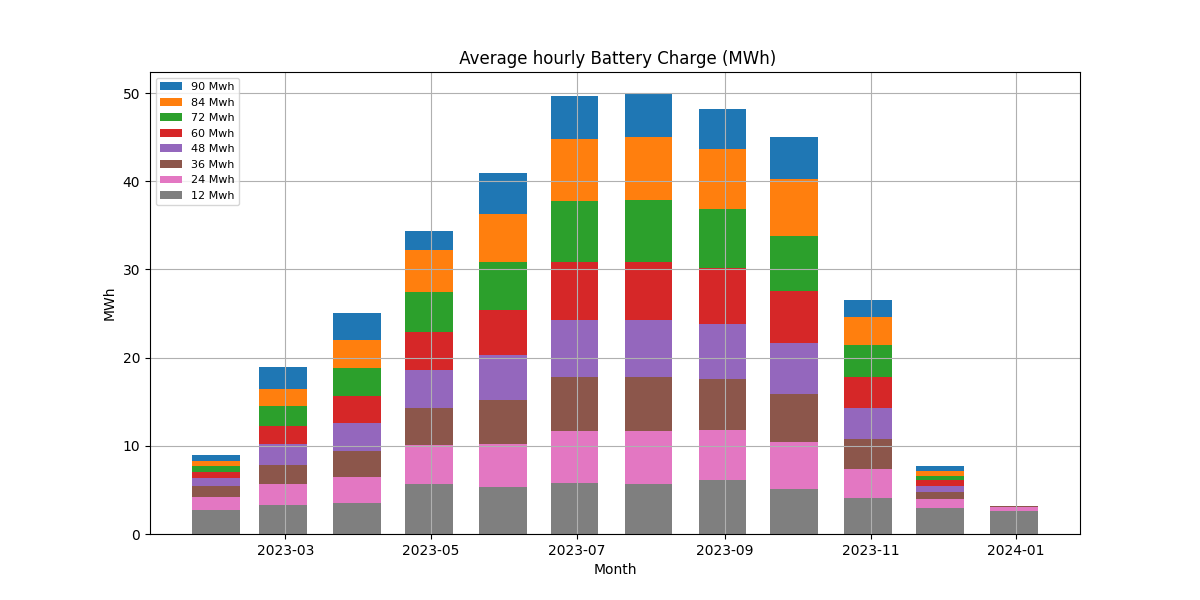

In [22]:
#plot the average hourly battery charge
plt.figure(figsize=(12, 6))


avg_monthly_battery_charge=battery_charge_df.resample('M').mean()

bat_8=plt.bar(avg_monthly_battery_charge.index,avg_monthly_battery_charge['90MWh'],label='90 Mwh',width=20)
bat_7=plt.bar(avg_monthly_battery_charge.index,avg_monthly_battery_charge['84MWh'],label='84 Mwh',width=20)
bat_6=plt.bar(avg_monthly_battery_charge.index,avg_monthly_battery_charge['72MWh'],label='72 Mwh',width=20)
bat_5=plt.bar(avg_monthly_battery_charge.index,avg_monthly_battery_charge['60MWh'],label='60 Mwh',width=20)
bat_4=plt.bar(avg_monthly_battery_charge.index,avg_monthly_battery_charge['48MWh'],label='48 Mwh',width=20)
bat_3=plt.bar(avg_monthly_battery_charge.index,avg_monthly_battery_charge['36MWh'],label='36 Mwh',width=20)
bat_2=plt.bar(avg_monthly_battery_charge.index,avg_monthly_battery_charge['24MWh'],label='24 Mwh',width=20)
bat_1=plt.bar(avg_monthly_battery_charge.index,avg_monthly_battery_charge['12MWh'],label='12 Mwh',width=20)






plt.legend(loc='upper left', fontsize=8, prop={'size': 8})
plt.title(' Average hourly Battery Charge (MWh)')
plt.xlabel('Month')
plt.ylabel('MWh')
plt.grid(True,zorder=0)
plt.show()

In [25]:
# Explicitly set any 0 values to NaN if needed
#energy_consumption_battery_df.replace(0, np.nan, inplace=True)
energy_consumption_no_battery.replace(0, np.nan, inplace=True)
#df_cleaned.replace(0, np.nan, inplace=True)



# Drop NaN values
#energy_consumption_battery_cleaned = energy_consumption_battery.dropna()
energy_consumption_no_battery_cleaned = energy_consumption_no_battery.dropna()






In [ ]:
print(f"the number of hours where the energy is greater than minimum speicified energy ({min_energy_consumption}) MWh is ({len(energy_consumption_battery_cleaned) - len(energy_consumption_no_battery_cleaned) }) hours after a battery was added ")
print(f"the number of hours where the energy is less than minimum speicified energy ({min_energy_consumption}) MWh is ({len(df_cleaned.dropna(inplace=False)) - len(energy_consumption_no_battery_cleaned)}) hours")

the number of hours where the energy is greater than minimum speicified energy (6) MWh is (1551) hours after a battery was added 
the number of hours where the energy is less than minimum speicified energy (6) MWh is (363) hours


In [26]:
energy_consumption_cleaned_month=energy_consumption_battery_df.resample('M').sum()
energy_consumption_no_battery_cleaned_month=energy_consumption_no_battery_cleaned.resample('M').sum()

C:\Users\alyou\AppData\Local\Temp\ipykernel_33708\83769679.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  energy_consumption_cleaned_month=energy_consumption_battery_df.resample('M').sum()
C:\Users\alyou\AppData\Local\Temp\ipykernel_33708\83769679.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  energy_consumption_no_battery_cleaned_month=energy_consumption_no_battery_cleaned.resample('M').sum()


In [27]:
#now we want to know energy generated vs energy consumed
#resample df_cleaned to monthly
df_cleaned_month=df_cleaned.resample('M').sum()

C:\Users\alyou\AppData\Local\Temp\ipykernel_33708\2211945167.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_cleaned_month=df_cleaned.resample('M').sum()


In [33]:
battery_names = energy_consumption_cleaned_month.columns

# Initialize the DataFrame to store energy differences
energy_difference_df = pd.DataFrame(index=energy_consumption_cleaned_month.index, columns=battery_names)

# Calculate the monthly differences for each battery
for battery_name in battery_names:
    energy_difference_df[battery_name] =energy_consumption_no_battery_cleaned_month  - energy_consumption_cleaned_month[battery_name]

# Calculate the sum of differences for each battery over all months
energy_difference_sum = energy_difference_df.sum()

# Print the resulting DataFrame and the sum of differences

print("\nSum of Monthly Energy Differences for Each Battery:\n", energy_difference_sum)


Sum of Monthly Energy Differences for Each Battery:
 12MWh    183272.157412
24MWh    180289.198714
36MWh    177422.611645
48MWh    174634.404840
60MWh    171901.148160
72MWh    169239.553673
84MWh    166635.957404
90MWh    165894.251731
dtype: float64
